# Binarna klasifikacija uz RFE odabir atributa

In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import losses, optimizers

from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn import datasets
from sklearn import model_selection
from sklearn import feature_selection
from sklearn import linear_model

import category_encoders as ce
from keras.callbacks import TensorBoard
import imblearn

np.random.seed(10)

Using TensorFlow backend.


In [2]:
data = pd.read_csv('kddcup.csv.data_10_percent_corrected')

data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


U svesci Provera reprezentativnosti uzorka + informacije o podacima, saznali smo da atributi 'num_outbound_cmds' i 'is_host_login' imaju sve 0, samim tim, nisu od znacaja za ucenje naseg modela pa se izbacuju.

In [3]:
data.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1, inplace = True)

In [4]:
y = data['class']

y = [instance!='normal.' for instance in y]

np.bincount(y)

array([ 97278, 396743])

In [5]:
encoder = ce.BinaryEncoder(data, cols = ['protocol_type', 'service', 'flag'])
X = encoder.fit_transform(data)

X = X.drop(columns = ['class'], axis = 1)

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.33, stratify=y, random_state=7)

In [7]:
X_train.shape

(330994, 52)

In [8]:
X_test.shape

(163027, 52)

In [9]:
np.bincount(y_train)

array([ 65176, 265818])

In [10]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
model_l = linear_model.LinearRegression()

In [12]:
rfe = feature_selection.RFE(model_l, n_features_to_select=30, verbose=1)

In [13]:
rfe.fit(X_train, y_train)

Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=30, step=1, verbose=1)

In [14]:
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

In [15]:
model = Sequential()
model.add(Dense(units=150, input_dim=X_train_rfe.shape[1], activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizers.Adam(learning_rate = 0.0001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
history = model.fit(X_train_rfe, y_train, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

Train on 264795 samples, validate on 66199 samples
Epoch 1/50
264795/264795 [==============================] - 120s 455us/step - loss: 0.0227 - accuracy: 0.9945 - val_loss: 0.0057 - val_accuracy: 0.9987
Epoch 2/50
264795/264795 [==============================] - 130s 490us/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.0040 - val_accuracy: 0.9988
Epoch 3/50
264795/264795 [==============================] - 131s 496us/step - loss: 0.0031 - accuracy: 0.9991 - val_loss: 0.0034 - val_accuracy: 0.9991
Epoch 4/50
264795/264795 [==============================] - 131s 494us/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0031 - val_accuracy: 0.9992
Epoch 5/50
264795/264795 [==============================] - 132s 499us/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0042 - val_accuracy: 0.9985
Epoch 6/50
264795/264795 [==============================] - 131s 495us/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9992
Epoch 7/50
264795/264795 [===========

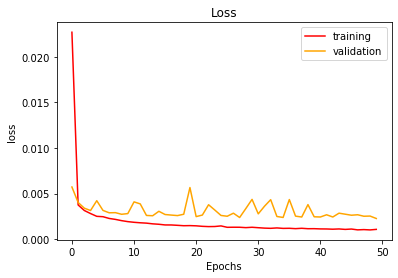

In [17]:
epochs = history.epoch

loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.plot(epochs, loss, c='red', label='training')
plt.plot(epochs, validation_loss, c='orange', label='validation')
plt.legend(loc='best')

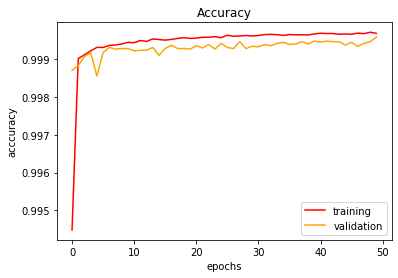

In [18]:
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('acccuracy')
plt.plot(epochs, acc, c='red', label='training')
plt.plot(epochs, validation_acc, c='orange', label='validation')
plt.legend(loc='best')

In [19]:
y_predicted = model.predict(X_test_rfe)

In [20]:
loss_v, acc_v = model.evaluate(X_test_rfe, y_test)

163027/163027 [==============================] - 30s 187us/step


In [21]:
loss_v

0.0018936317775040856

In [22]:
acc_v

0.9995522499084473

In [23]:
loss_t, acc_t = model.evaluate(X_train_rfe, y_train)

330994/330994 [==============================] - 60s 181us/step


In [24]:
loss_t

0.0011345253804490073

In [25]:
acc_t

0.9997130036354065

In [26]:
y_predicted = [int(prediction >= 0.5) for prediction in y_predicted]

In [27]:
np.bincount(y_predicted)

array([ 32127, 130900])

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

In [29]:
print(confusion_matrix(y_predicted, y_test))

[[ 32078     49]
 [    24 130876]]


In [30]:
print(classification_report(y_predicted, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32127
           1       1.00      1.00      1.00    130900

    accuracy                           1.00    163027
   macro avg       1.00      1.00      1.00    163027
weighted avg       1.00      1.00      1.00    163027

